In [1]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import yaml
from datetime import datetime

# Configuración de visualizaciones
plt.style.use('seaborn-v0_8')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
%matplotlib inline

# Añadir el directorio src al path para poder importar los módulos personalizados
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Importar funciones de preprocesamiento
from src.preprocess import cargar_datos_brutos, calcular_retornos, detectar_outliers, manejar_outliers, \
                          manejar_datos_faltantes, calcular_indicadores_tecnicos, \
                          unificar_datos, guardar_datos_procesados

## Carga de configuración

Primero cargamos la configuración del proyecto desde el archivo `config.yaml`.

In [2]:
# Cargar configuración desde archivo
with open('../config.yaml', 'r') as file:
    config = yaml.safe_load(file)

# Verificar período de análisis
fecha_inicio = config['periodo_analisis']['fecha_inicio']
fecha_fin = config['periodo_analisis']['fecha_fin']

print(f"Período de análisis: {fecha_inicio} a {fecha_fin}")

# Mostrar empresas por sector para verificación
for sector, empresas in config['empresas'].items():
    print(f"\nSector: {sector}")
    for empresa in empresas:
        print(f"  - {empresa['nombre']} ({empresa['ticker']})")

Período de análisis: 2022-05-09 a 2025-05-09

Sector: tecnologia
  - Microsoft (MSFT)
  - Alphabet (GOOG)
  - Meta Platforms (META)
  - Amazon (AMZN)
  - NVIDIA (NVDA)

Sector: salud_farmaceuticas
  - Johnson & Johnson (JNJ)
  - Merck & Co. (MRK)
  - Pfizer (PFE)
  - Bristol Myers Squibb (BMY)
  - Eli Lilly (LLY)


## Carga de datos crudos

Cargamos los datos desde los archivos CSV guardados en `data/raw/` que contienen la información histórica de cada empresa.

In [3]:
# Cargar datos brutos
datos_brutos = cargar_datos_brutos(config=config)

# Información básica del DataFrame
print(f"Dimensiones del DataFrame: {datos_brutos.shape}")
print(f"\nPrimeras filas del DataFrame:")
display(datos_brutos.head())

print(f"\nInformación sobre el DataFrame:")
datos_brutos.info()

print(f"\nResumen estadístico:")
display(datos_brutos.describe())

Dimensiones del DataFrame: (7530, 8)

Primeras filas del DataFrame:


,Date,Ticker,Close,High,Low,Open,Volume,Sector
0,2022-05-09,AMZN,108.789001,114.000000,107.957001,111.312500,128124000,tecnologia
753,2022-05-09,BMY,67.603874,68.472525,66.354088,67.089781,19130700,salud_farmaceuticas
1506,2022-05-09,GOOG,112.550903,115.018114,112.020912,112.769366,34520000,tecnologia
2259,2022-05-09,JNJ,162.299271,163.425010,159.791512,160.578618,7855200,salud_farmaceuticas
3012,2022-05-09,LLY,281.398193,286.943830,278.888038,285.562298,3460500,salud_farmaceuticas



Información sobre el DataFrame:
<class 'pandas.core.frame.DataFrame'>
Index: 7530 entries, 0 to 7529
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    7530 non-null   datetime64[ns]
 1   Ticker  7530 non-null   object        
 2   Close   7530 non-null   float64       
 3   High    7530 non-null   float64       
 4   Low     7530 non-null   float64       
 5   Open    7530 non-null   float64       
 6   Volume  7530 non-null   int64         
 7   Sector  7530 non-null   object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 529.5+ KB

Resumen estadístico:


,Date,Close,High,Low,Open,Volume
count,7530,7530.000000,7530.000000,7530.000000,7530.000000,7.530000e+03
mean,2023-11-06 21:49:57.609562112,198.775028,201.071682,196.351226,198.740147,6.269592e+07
min,2022-05-09 00:00:00,11.214939,11.722393,10.801383,10.959213,9.960000e+05
25%,2023-02-07 00:00:00,67.490877,68.071445,66.788420,67.507450,8.331975e+06
50%,2023-11-06 00:00:00,137.170296,138.820000,135.259340,137.122133,1.816810e+07
75%,2024-08-07 00:00:00,248.138851,251.722248,245.948111,249.355283,3.531378e+07
max,2025-05-08 00:00:00,956.783691,969.251584,948.372156,954.541291,1.543911e+09
std,NaN,192.987625,195.358762,190.533314,193.060537,1.369869e+08


### Verificar disponibilidad de datos por empresa

Vamos a comprobar que tenemos datos para todas las empresas y el rango de fechas para cada una.

In [4]:
# Verificar disponibilidad de datos por empresa
datos_por_empresa = {}
for ticker in datos_brutos['Ticker'].unique():
    datos_ticker = datos_brutos[datos_brutos['Ticker'] == ticker]
    datos_por_empresa[ticker] = {
        'filas': len(datos_ticker),
        'fecha_inicio': datos_ticker['Date'].min(),
        'fecha_fin': datos_ticker['Date'].max(),
        'dias': (datos_ticker['Date'].max() - datos_ticker['Date'].min()).days,
        'sector': datos_ticker['Sector'].iloc[0],
    }

# Convertir a DataFrame para una mejor visualización
verificacion_datos = pd.DataFrame.from_dict(datos_por_empresa, orient='index')
verificacion_datos = verificacion_datos.sort_values(by='filas', ascending=False)
display(verificacion_datos)

,filas,fecha_inicio,fecha_fin,dias,sector
AMZN,753,2022-05-09,2025-05-08,1095,tecnologia
BMY,753,2022-05-09,2025-05-08,1095,salud_farmaceuticas
GOOG,753,2022-05-09,2025-05-08,1095,tecnologia
JNJ,753,2022-05-09,2025-05-08,1095,salud_farmaceuticas
LLY,753,2022-05-09,2025-05-08,1095,salud_farmaceuticas
META,753,2022-05-09,2025-05-08,1095,tecnologia
MRK,753,2022-05-09,2025-05-08,1095,salud_farmaceuticas
MSFT,753,2022-05-09,2025-05-08,1095,tecnologia
NVDA,753,2022-05-09,2025-05-08,1095,tecnologia
PFE,753,2022-05-09,2025-05-08,1095,salud_farmaceuticas


### Verificar valores faltantes

Vamos a analizar si existen valores faltantes en el conjunto de datos.

In [5]:
# Verificar valores faltantes
valores_faltantes = datos_brutos.isnull().sum()
porcentaje_faltantes = valores_faltantes / len(datos_brutos) * 100

# Crear DataFrame para visualización
resumen_faltantes = pd.DataFrame({
    'Valores Faltantes': valores_faltantes,
    'Porcentaje': porcentaje_faltantes
})

print("Resumen de valores faltantes por columna:")
display(resumen_faltantes)

# Visualizar valores faltantes si existen
if valores_faltantes.sum() > 0:
    plt.figure(figsize=(12, 6))
    sns.heatmap(datos_brutos.isnull(), cbar=False, cmap='viridis', yticklabels=False)
    plt.title('Mapa de valores faltantes')
    plt.tight_layout()
    plt.show()
else:
    print("No existen valores faltantes en el conjunto de datos.")

Resumen de valores faltantes por columna:


,Valores Faltantes,Porcentaje
Date,0,0.0
Ticker,0,0.0
Close,0,0.0
High,0,0.0
Low,0,0.0
Open,0,0.0
Volume,0,0.0
Sector,0,0.0


No existen valores faltantes en el conjunto de datos.


## Aplicación del procesamiento de datos

Ahora aplicaremos las funciones de preprocesamiento a los datos brutos.

In [6]:
# Calcular retornos diarios
print("Calculando retornos diarios...")
datos_con_retornos = calcular_retornos(datos_brutos, metodo='simple', columna_precio='Close')
print("Retornos calculados.\n")

# Mostrar ejemplo de los datos con retornos calculados
display(datos_con_retornos.head())

# Verificar columnas añadidas
columnas_nuevas = set(datos_con_retornos.columns) - set(datos_brutos.columns)
print(f"Columnas añadidas: {columnas_nuevas}")

Calculando retornos diarios...
Retornos calculados.



,Date,Ticker,Close,High,Low,Open,Volume,Sector,Retorno,RetornoAcumulado
0,2022-05-09,AMZN,108.789001,114.000000,107.957001,111.312500,128124000,tecnologia,NaN,NaN
753,2022-05-09,BMY,67.603874,68.472525,66.354088,67.089781,19130700,salud_farmaceuticas,NaN,NaN
1506,2022-05-09,GOOG,112.550903,115.018114,112.020912,112.769366,34520000,tecnologia,NaN,NaN
2259,2022-05-09,JNJ,162.299271,163.425010,159.791512,160.578618,7855200,salud_farmaceuticas,NaN,NaN
3012,2022-05-09,LLY,281.398193,286.943830,278.888038,285.562298,3460500,salud_farmaceuticas,NaN,NaN


Columnas añadidas: {'RetornoAcumulado', 'Retorno'}


### Análisis de retornos

Vamos a analizar brevemente la distribución de los retornos para detectar posibles outliers.

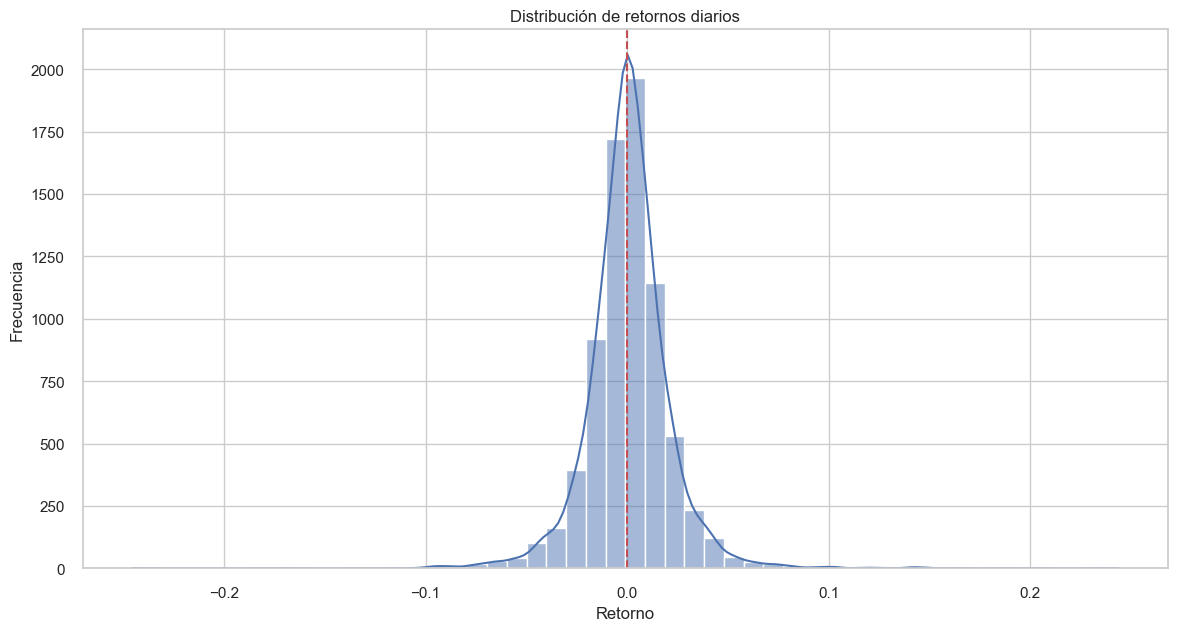

Estadísticas descriptivas de los retornos:


count    7520.000000
mean        0.000809
std         0.021138
min        -0.245571
25%        -0.009298
50%         0.000646
75%         0.010587
max         0.243696
Name: Retorno, dtype: float64

In [7]:
# Histograma de retornos
plt.figure(figsize=(14, 7))
sns.histplot(datos_con_retornos['Retorno'].dropna(), kde=True, bins=50)
plt.title('Distribución de retornos diarios')
plt.xlabel('Retorno')
plt.ylabel('Frecuencia')
plt.axvline(x=0, color='r', linestyle='--')
plt.grid(True)
plt.show()

# Estadísticas descriptivas de los retornos
print("Estadísticas descriptivas de los retornos:")
display(datos_con_retornos['Retorno'].describe())

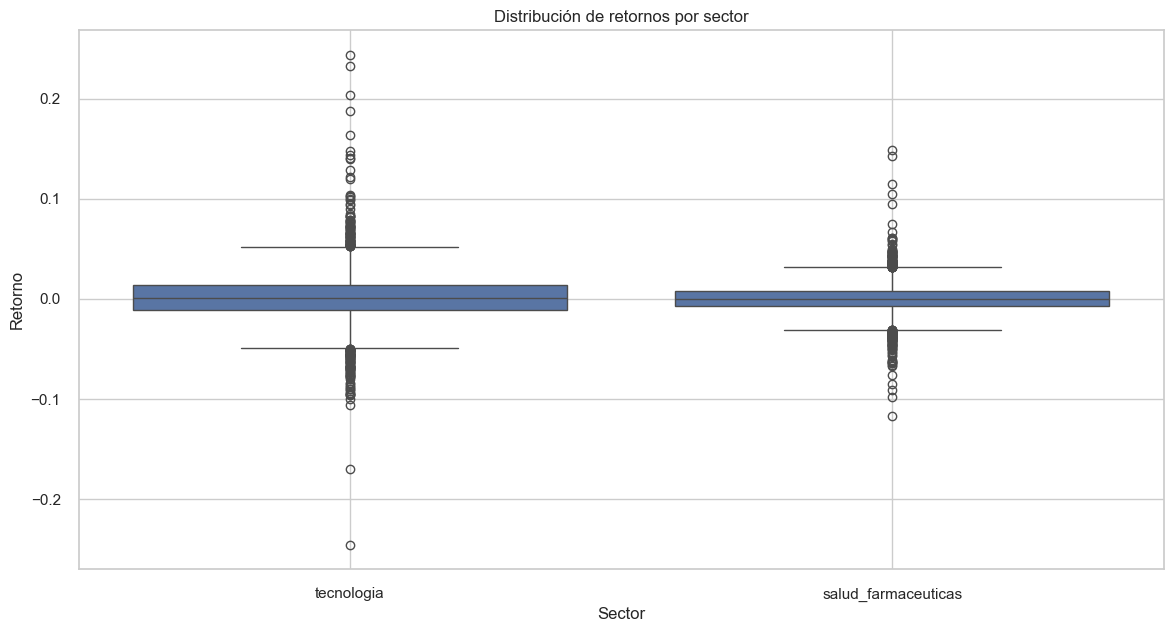

In [8]:
# Diagrama de caja para identificar outliers en retornos por sector
plt.figure(figsize=(14, 7))
sns.boxplot(x='Sector', y='Retorno', data=datos_con_retornos)
plt.title('Distribución de retornos por sector')
plt.xlabel('Sector')
plt.ylabel('Retorno')
plt.grid(True)
plt.show()

### Detección y manejo de valores atípicos

Detectaremos y manejaremos los valores atípicos en la columna de retornos.

Detectando outliers en retornos...
Número de outliers detectados (Z-score): 116
Número de outliers detectados (IQR): 427


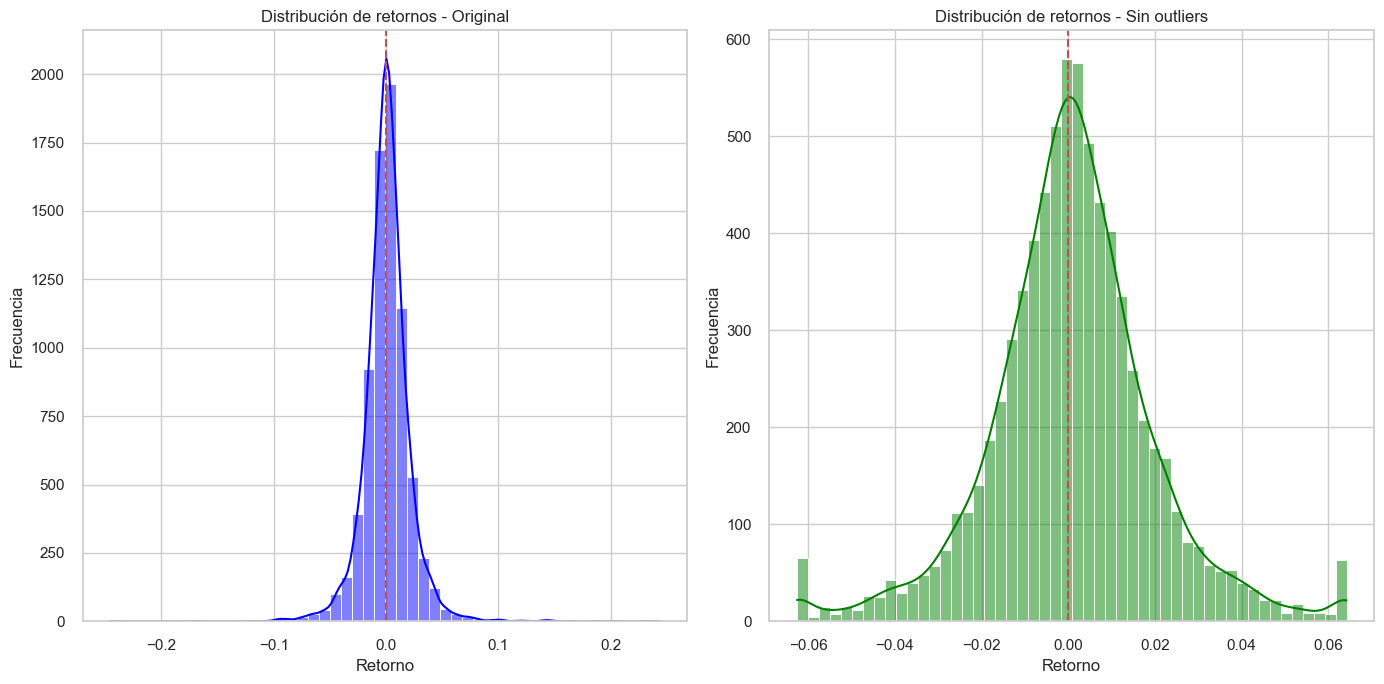

In [9]:
# Detectar outliers en retornos usando Z-score
print("Detectando outliers en retornos...")
outliers_zscore = detectar_outliers(datos_con_retornos, 'Retorno', metodo='zscore', umbral=3.0)
print(f"Número de outliers detectados (Z-score): {outliers_zscore.sum()}")

# Detectar outliers usando IQR
outliers_iqr = detectar_outliers(datos_con_retornos, 'Retorno', metodo='iqr', umbral=1.5)
print(f"Número de outliers detectados (IQR): {outliers_iqr.sum()}")

# Manejar outliers usando el método de recorte (clip)
datos_sin_outliers = manejar_outliers(datos_con_retornos, 'Retorno', metodo_deteccion='zscore', metodo_manejo='clip', umbral=3.0)

# Comparar distribuciones antes y después del manejo de outliers
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
sns.histplot(datos_con_retornos['Retorno'].dropna(), kde=True, bins=50, color='blue')
plt.title('Distribución de retornos - Original')
plt.xlabel('Retorno')
plt.ylabel('Frecuencia')
plt.axvline(x=0, color='r', linestyle='--')
plt.grid(True)

plt.subplot(1, 2, 2)
sns.histplot(datos_sin_outliers['Retorno'].dropna(), kde=True, bins=50, color='green')
plt.title('Distribución de retornos - Sin outliers')
plt.xlabel('Retorno')
plt.ylabel('Frecuencia')
plt.axvline(x=0, color='r', linestyle='--')
plt.grid(True)

plt.tight_layout()
plt.show()

### Manejo de datos faltantes

Manejaremos los posibles datos faltantes en el conjunto de datos.

In [10]:
# Verificar si existen datos faltantes después del cálculo de retornos
valores_faltantes_retornos = datos_sin_outliers.isnull().sum()
print("Valores faltantes por columna después de calcular retornos:")
display(valores_faltantes_retornos)

# Manejar datos faltantes usando interpolación
datos_completos = manejar_datos_faltantes(datos_sin_outliers, metodo='interpolar')

# Verificar que no queden datos faltantes
valores_faltantes_final = datos_completos.isnull().sum()
print("\nValores faltantes después del proceso de interpolación:")
display(valores_faltantes_final)

Valores faltantes por columna después de calcular retornos:


Date                 0
Ticker               0
Close                0
High                 0
Low                  0
Open                 0
Volume               0
Sector               0
Retorno             10
RetornoAcumulado    10
dtype: int64


Valores faltantes después del proceso de interpolación:


Date                 0
Ticker               0
Close                0
High                 0
Low                  0
Open                 0
Volume               0
Sector               0
Retorno             10
RetornoAcumulado    10
dtype: int64

### Cálculo de indicadores técnicos

Añadiremos indicadores técnicos financieros que serán útiles para el análisis posterior.

In [11]:
# Calcular indicadores técnicos
print("Calculando indicadores técnicos...")
datos_con_indicadores = calcular_indicadores_tecnicos(datos_completos)
print("Indicadores técnicos calculados.\n")

# Mostrar ejemplo de los datos con indicadores técnicos
display(datos_con_indicadores.head())

# Verificar columnas añadidas
columnas_indicadores = set(datos_con_indicadores.columns) - set(datos_completos.columns)
print(f"Indicadores técnicos añadidos: {columnas_indicadores}")

Calculando indicadores técnicos...
Indicadores técnicos calculados.



,Date,Ticker,Close,High,Low,Open,Volume,Sector,Retorno,RetornoAcumulado,MA7,MA21,MA50,Volatilidad21,VolumenPromedio7,RSI
0,2022-05-09,AMZN,108.789001,114.000000,107.957001,111.312500,128124000,tecnologia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
753,2022-05-09,BMY,67.603874,68.472525,66.354088,67.089781,19130700,salud_farmaceuticas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1506,2022-05-09,GOOG,112.550903,115.018114,112.020912,112.769366,34520000,tecnologia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2259,2022-05-09,JNJ,162.299271,163.425010,159.791512,160.578618,7855200,salud_farmaceuticas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3012,2022-05-09,LLY,281.398193,286.943830,278.888038,285.562298,3460500,salud_farmaceuticas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Indicadores técnicos añadidos: {'Volatilidad21', 'MA7', 'MA50', 'MA21', 'VolumenPromedio7', 'RSI'}


### Unificación de todo el proceso de preprocesamiento

En lugar de aplicar cada paso por separado, podemos utilizar la función `unificar_datos` que realiza todo el proceso en un solo paso.

In [12]:
# Aplicar todo el proceso de preprocesamiento en un solo paso
print("Aplicando proceso completo de preprocesamiento...")
datos_procesados = unificar_datos(
    datos_brutos,
    metodo_retornos='simple',
    manejar_outliers_retornos=True,
    manejar_na='interpolar',
    calcular_tecnicos=True
)
print("Preprocesamiento completo.\n")

# Verificar que el resultado es el mismo
coincide_procesamiento = datos_con_indicadores.equals(datos_procesados)
print(f"El procesamiento paso a paso y el unificado producen el mismo resultado: {coincide_procesamiento}")

# Si hay diferencias, verificar qué columnas difieren
if not coincide_procesamiento:
    print("\nNota: Es normal que existan pequeñas diferencias numéricas debido al orden de las operaciones.")
    # Podemos utilizar el dataset procesado unificado para el resto del análisis

# Mostrar información del DataFrame procesado
print(f"\nDimensiones del DataFrame procesado: {datos_procesados.shape}")
datos_procesados.info()

Aplicando proceso completo de preprocesamiento...
Preprocesamiento completo.

El procesamiento paso a paso y el unificado producen el mismo resultado: True

Dimensiones del DataFrame procesado: (7530, 16)
<class 'pandas.core.frame.DataFrame'>
Index: 7530 entries, 0 to 7529
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              7530 non-null   datetime64[ns]
 1   Ticker            7530 non-null   object        
 2   Close             7530 non-null   float64       
 3   High              7530 non-null   float64       
 4   Low               7530 non-null   float64       
 5   Open              7530 non-null   float64       
 6   Volume            7530 non-null   int64         
 7   Sector            7530 non-null   object        
 8   Retorno           7520 non-null   float64       
 9   RetornoAcumulado  7520 non-null   float64       
 10  MA7               7470 non-null   float6

## Análisis exploratorio de los datos procesados

Ahora realizaremos un análisis exploratorio básico de los datos procesados.

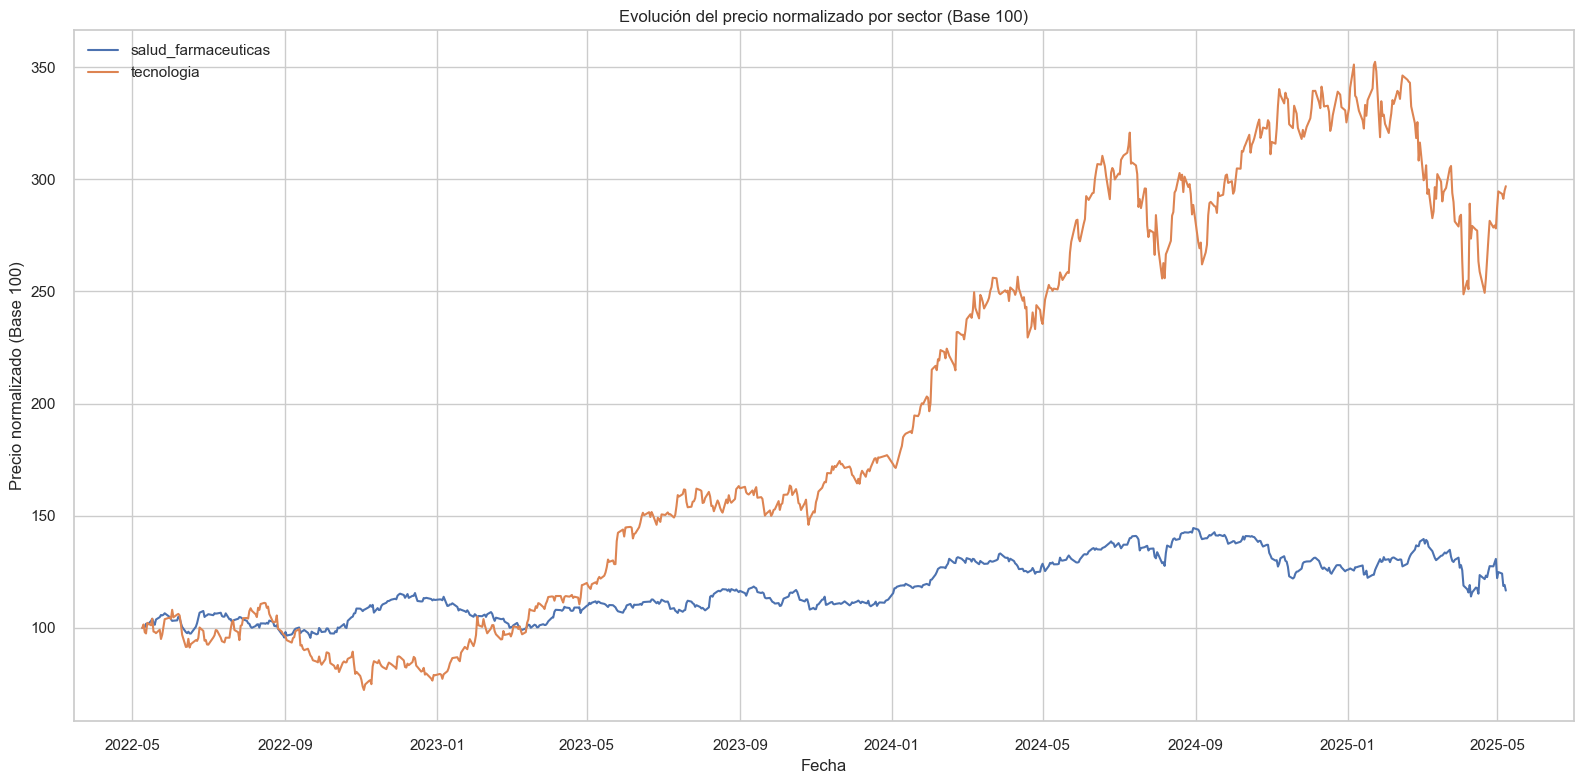

In [13]:
# Evolución de precios por sector
plt.figure(figsize=(16, 8))

# Normalizar precios para comparar evolución desde un punto base (precio inicial = 100)
datos_normalizados = datos_procesados.copy()

for ticker in datos_procesados['Ticker'].unique():
    mask = datos_procesados['Ticker'] == ticker
    datos_ticker = datos_procesados[mask].sort_values('Date')
    precio_inicial = datos_ticker['Close'].iloc[0]
    datos_normalizados.loc[mask, 'Precio_Normalizado'] = datos_ticker['Close'] / precio_inicial * 100

# Agrupar por sector y fecha para obtener el promedio
datos_sector = datos_normalizados.groupby(['Sector', 'Date'])['Precio_Normalizado'].mean().reset_index()

# Graficar la evolución por sector
for sector in datos_sector['Sector'].unique():
    datos_sector_filtrado = datos_sector[datos_sector['Sector'] == sector]
    plt.plot(datos_sector_filtrado['Date'], datos_sector_filtrado['Precio_Normalizado'], label=sector)

plt.title('Evolución del precio normalizado por sector (Base 100)')
plt.xlabel('Fecha')
plt.ylabel('Precio normalizado (Base 100)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

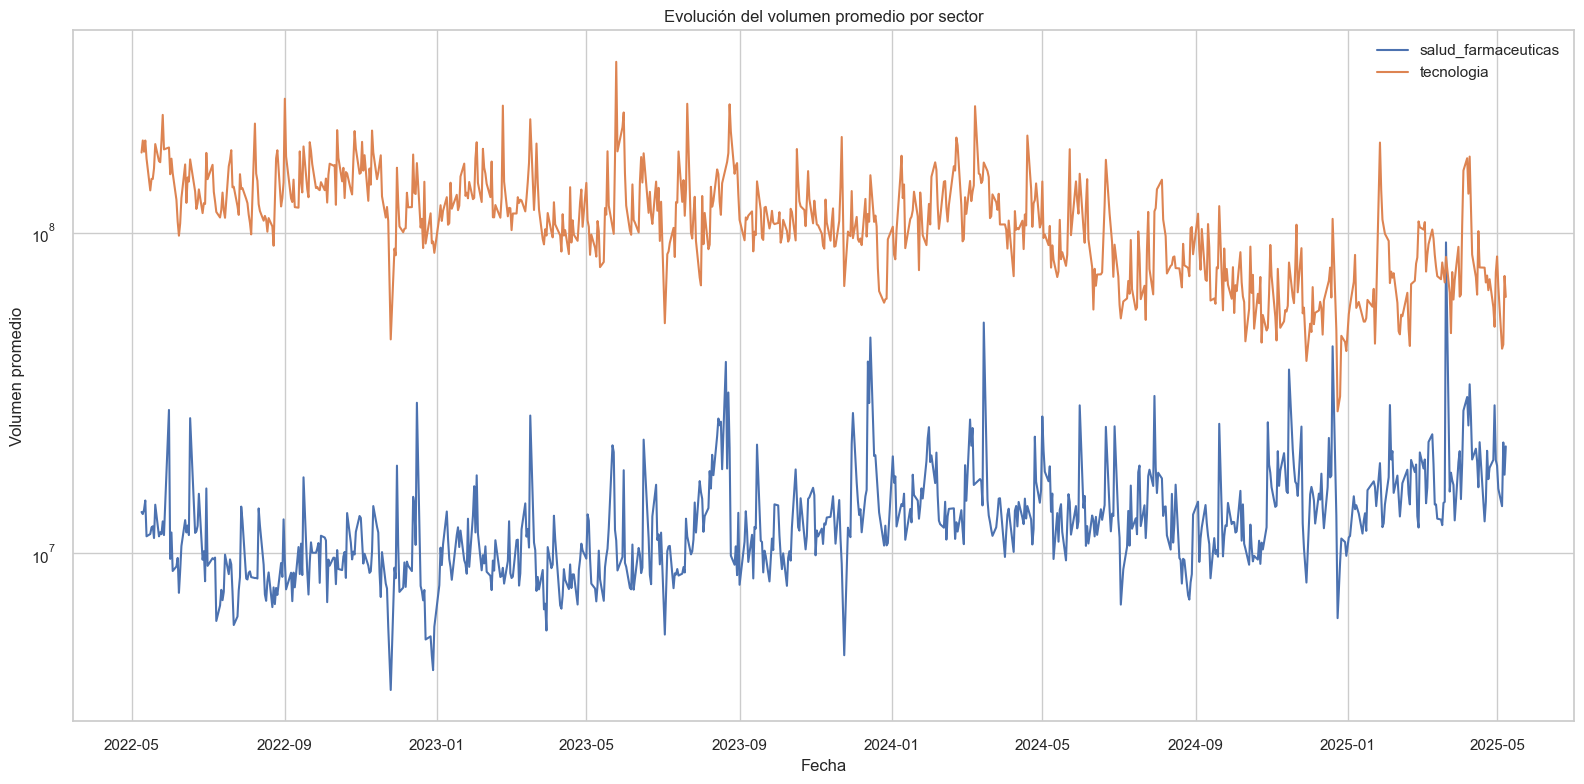

In [14]:
# Evolución del volumen promedio
plt.figure(figsize=(16, 8))

# Agrupar por sector y fecha para obtener el promedio del volumen
volumen_sector = datos_procesados.groupby(['Sector', 'Date'])['Volume'].mean().reset_index()

# Graficar la evolución del volumen por sector
for sector in volumen_sector['Sector'].unique():
    volumen_sector_filtrado = volumen_sector[volumen_sector['Sector'] == sector]
    plt.plot(volumen_sector_filtrado['Date'], volumen_sector_filtrado['Volume'], label=sector)

plt.title('Evolución del volumen promedio por sector')
plt.xlabel('Fecha')
plt.ylabel('Volumen promedio')
plt.grid(True)
plt.legend()
plt.yscale('log')
plt.tight_layout()
plt.show()

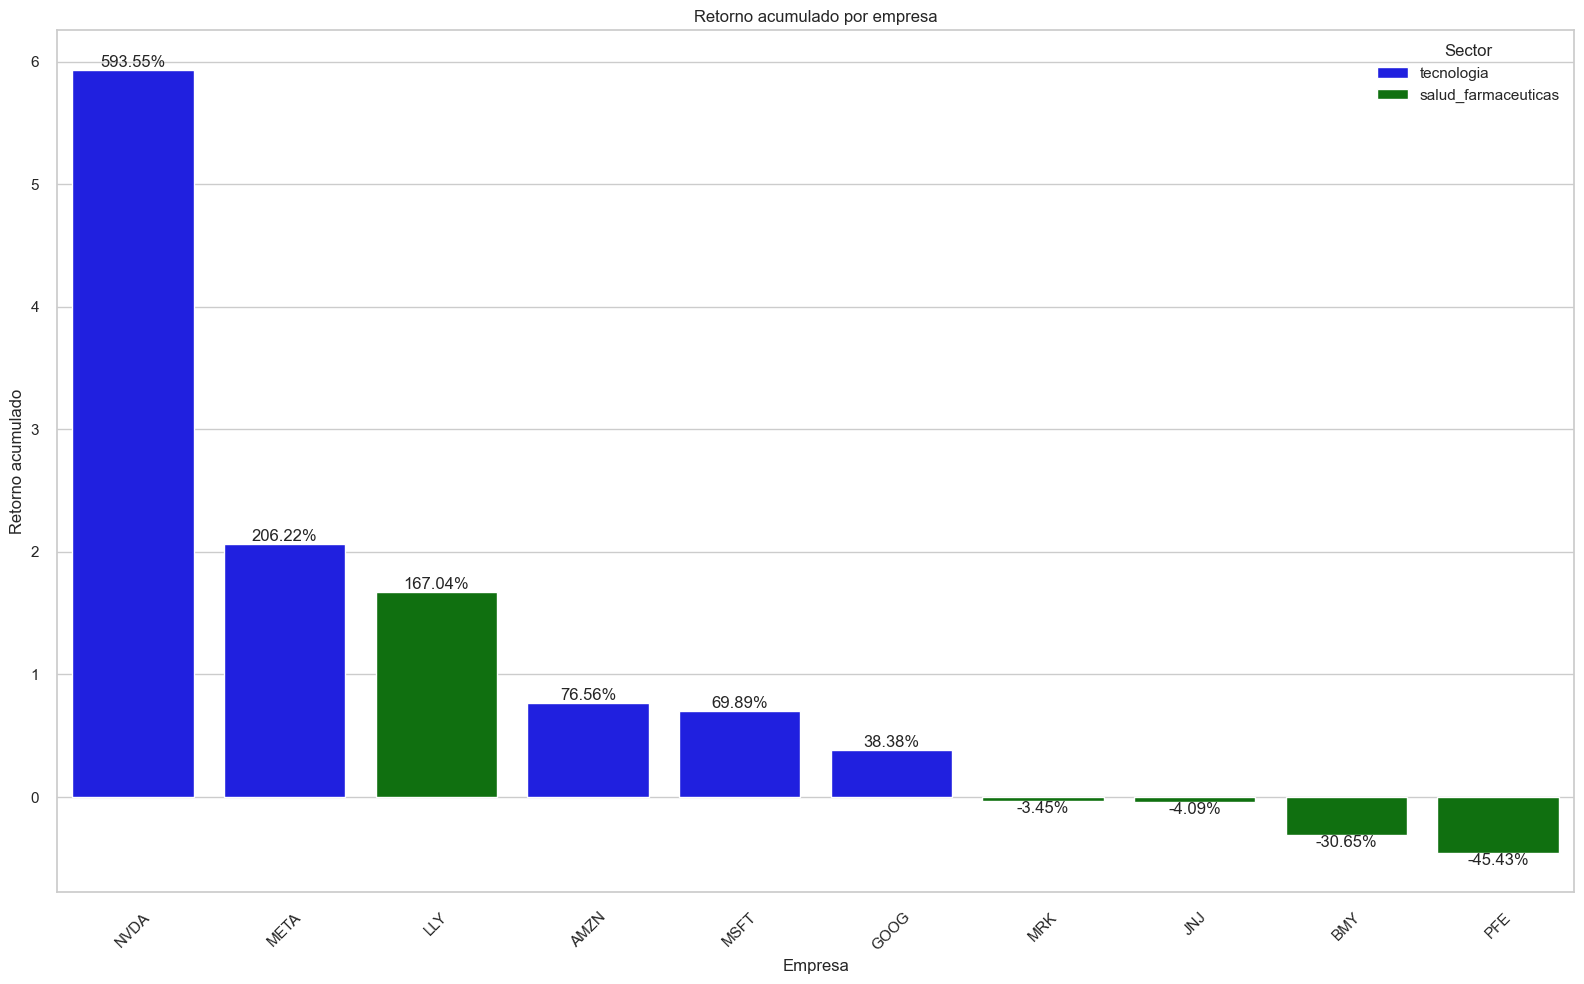

Resumen de retornos acumulados por empresa:


,Ticker,RetornoAcumulado,Sector
8,NVDA,5.935456,tecnologia
5,META,2.062170,tecnologia
4,LLY,1.670415,salud_farmaceuticas
0,AMZN,0.765620,tecnologia
7,MSFT,0.698941,tecnologia
2,GOOG,0.383818,tecnologia
6,MRK,-0.034506,salud_farmaceuticas
3,JNJ,-0.040908,salud_farmaceuticas
1,BMY,-0.306549,salud_farmaceuticas
9,PFE,-0.454346,salud_farmaceuticas


In [15]:
# Comparar retornos acumulados por empresa
plt.figure(figsize=(16, 10))

# Seleccionar la última fecha para cada ticker y obtener el retorno acumulado
retornos_por_empresa = []
for ticker in datos_procesados['Ticker'].unique():
    datos_ticker = datos_procesados[datos_procesados['Ticker'] == ticker].sort_values('Date')
    ultimo_retorno = datos_ticker['RetornoAcumulado'].iloc[-1]
    sector = datos_ticker['Sector'].iloc[0]
    retornos_por_empresa.append({'Ticker': ticker, 'RetornoAcumulado': ultimo_retorno, 'Sector': sector})

# Convertir a DataFrame y ordenar por retorno acumulado
df_retornos = pd.DataFrame(retornos_por_empresa).sort_values('RetornoAcumulado', ascending=False)

# Graficar retornos acumulados por empresa, coloreados por sector
colors = {'tecnologia': 'blue', 'salud_farmaceuticas': 'green'}
sns.barplot(x='Ticker', y='RetornoAcumulado', hue='Sector', data=df_retornos, palette=colors)
plt.title('Retorno acumulado por empresa')
plt.xlabel('Empresa')
plt.ylabel('Retorno acumulado')
plt.grid(True, axis='y')
plt.xticks(rotation=45)

# Añadir etiquetas con el valor porcentual
for i, row in enumerate(df_retornos.itertuples()):
    plt.text(i, row.RetornoAcumulado, f'{row.RetornoAcumulado:.2%}', 
             ha='center', va='bottom' if row.RetornoAcumulado > 0 else 'top')

plt.tight_layout()
plt.show()

# Mostrar tabla con los retornos acumulados
print("Resumen de retornos acumulados por empresa:")
display(df_retornos)

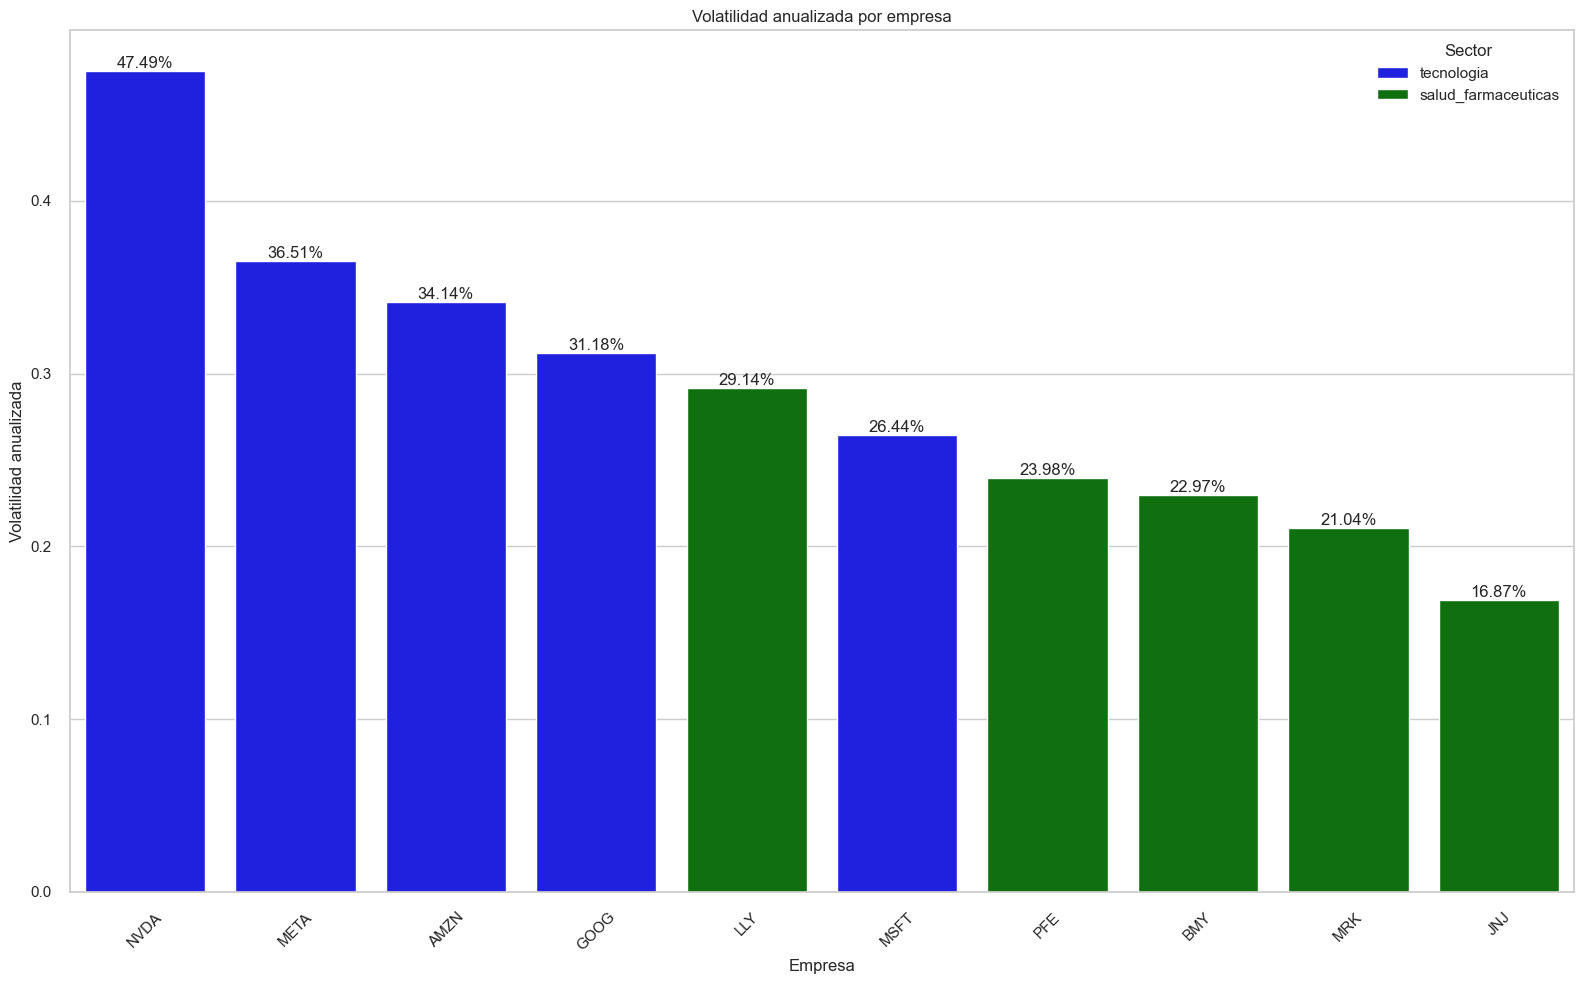

Resumen de volatilidad anualizada por empresa:


,Ticker,Volatilidad,Sector
8,NVDA,0.474889,tecnologia
5,META,0.365118,tecnologia
0,AMZN,0.341425,tecnologia
2,GOOG,0.311770,tecnologia
4,LLY,0.291448,salud_farmaceuticas
7,MSFT,0.264426,tecnologia
9,PFE,0.239789,salud_farmaceuticas
1,BMY,0.229700,salud_farmaceuticas
6,MRK,0.210431,salud_farmaceuticas
3,JNJ,0.168717,salud_farmaceuticas


In [16]:
# Comparar volatilidad por empresa
plt.figure(figsize=(16, 10))

# Calcular la volatilidad (desviación estándar de retornos diarios) por empresa
volatilidad_por_empresa = []
for ticker in datos_procesados['Ticker'].unique():
    datos_ticker = datos_procesados[datos_procesados['Ticker'] == ticker]
    volatilidad = datos_ticker['Retorno'].std() * (252 ** 0.5)  # Anualizada (252 días de trading)
    sector = datos_ticker['Sector'].iloc[0]
    volatilidad_por_empresa.append({'Ticker': ticker, 'Volatilidad': volatilidad, 'Sector': sector})

# Convertir a DataFrame y ordenar por volatilidad
df_volatilidad = pd.DataFrame(volatilidad_por_empresa).sort_values('Volatilidad', ascending=False)

# Graficar volatilidad por empresa, coloreados por sector
sns.barplot(x='Ticker', y='Volatilidad', hue='Sector', data=df_volatilidad, palette=colors)
plt.title('Volatilidad anualizada por empresa')
plt.xlabel('Empresa')
plt.ylabel('Volatilidad anualizada')
plt.grid(True, axis='y')
plt.xticks(rotation=45)

# Añadir etiquetas con el valor porcentual
for i, row in enumerate(df_volatilidad.itertuples()):
    plt.text(i, row.Volatilidad, f'{row.Volatilidad:.2%}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Mostrar tabla con la volatilidad
print("Resumen de volatilidad anualizada por empresa:")
display(df_volatilidad)

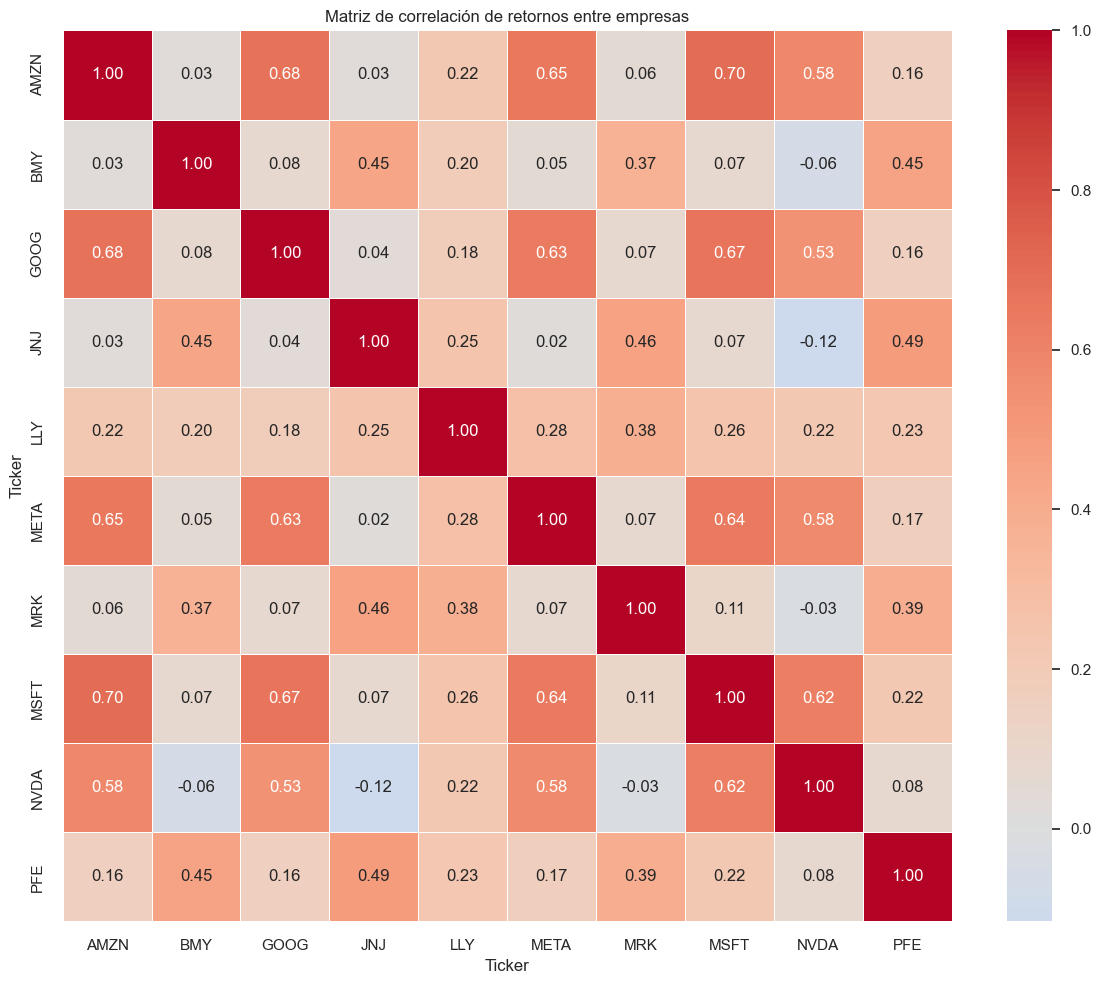

In [17]:
# Matriz de correlación de retornos entre empresas
# Pivotear el DataFrame para tener fechas como índice y tickers como columnas
pivot_retornos = datos_procesados.pivot_table(index='Date', columns='Ticker', values='Retorno')

# Calcular la matriz de correlación
corr_matrix = pivot_retornos.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', linewidths=0.5)
plt.title('Matriz de correlación de retornos entre empresas')
plt.tight_layout()
plt.show()

## Exportación del dataset limpio

Finalmente, guardaremos el dataset procesado en `data/processed/` para ser utilizado en el análisis y modelado posterior.

In [18]:
# Guardar datos procesados
ruta_salida = guardar_datos_procesados(datos_procesados, config=config, formato='csv')
print(f"Dataset procesado guardado en: {ruta_salida}")

Datos guardados en: c:\Users\Marco\Documents\Quinto Ciclo\Estadistica\analisis-inversion\data/processed/datos_financieros_procesados_20250510.csv
Dataset procesado guardado en: c:\Users\Marco\Documents\Quinto Ciclo\Estadistica\analisis-inversion\data/processed/datos_financieros_procesados_20250510.csv


## Resumen y conclusiones

En este notebook hemos realizado el proceso de limpieza y preprocesamiento de los datos financieros:

1. **Datos cargados**: Se unificaron los datos de todas las empresas en un único DataFrame.
2. **Cálculo de retornos**: Se calcularon los retornos diarios y acumulados para cada empresa.
3. **Manejo de outliers**: Se detectaron y manejaron los valores atípicos en los retornos.
4. **Datos faltantes**: Se interpolaron los valores faltantes en el conjunto de datos.
5. **Indicadores técnicos**: Se añadieron indicadores financieros relevantes como medias móviles, RSI y volatilidad.
6. **Análisis exploratorio**: Se realizaron visualizaciones para entender mejor los datos y las relaciones entre empresas.
7. **Exportación**: El dataset limpio fue guardado para su uso en las siguientes etapas del proyecto.
